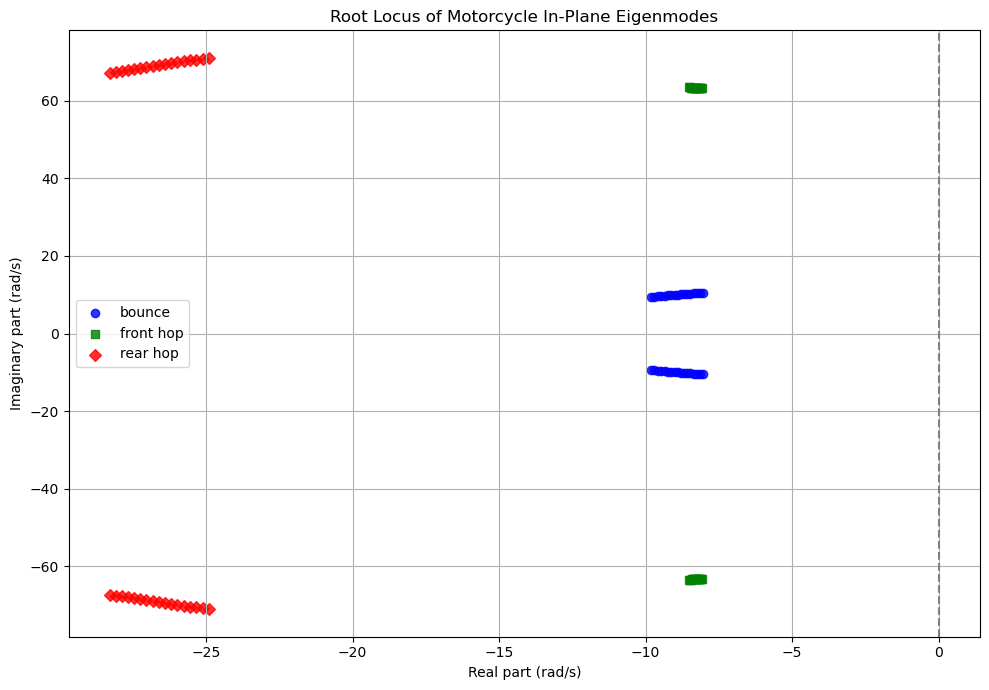

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

# --- Physical parameters ---
m_s = 180     # Sprung mass (kg)
m_uf = 40     # Unsprung mass front (kg)
m_ur = 30     # Unsprung mass rear (kg)
l_f = 1.0     # Distance CG to front wheel (m)
l_r = 1.0     # Distance CG to rear wheel (m)

k_f = 15000   # Front suspension stiffness (N/m)
k_r = 15000   # Rear suspension stiffness (N/m)
k_tf = 200000 # Front tire stiffness (N/m)
k_tr = 200000 # Rear tire stiffness (N/m)

c_f = 1500    # Front suspension damping (Ns/m)
c_r = 1500    # Rear suspension damping (Ns/m)
c_tf = 200    # Front tire damping (Ns/m)
c_tr = 200    # Rear tire damping (Ns/m)

I_yy = m_s * (l_f**2 + l_r**2) / 12

# --- Matrices ---
M = np.array([
    [m_s, 0, 0, 0],
    [0, I_yy, 0, 0],
    [0, 0, m_uf, 0],
    [0, 0, 0, m_ur]
])

K = np.array([
    [k_f + k_r, k_f * l_f - k_r * l_r, -k_f, -k_r],
    [k_f * l_f - k_r * l_r, k_f * l_f**2 + k_r * l_r**2, -k_f * l_f, k_r * l_r],
    [-k_f, -k_f * l_f, k_f + k_tf, 0],
    [-k_r, k_r * l_r, 0, k_r + k_tr]
])

C = np.array([
    [c_f + c_r, c_f * l_f - c_r * l_r, -c_f, -c_r],
    [c_f * l_f - c_r * l_r, c_f * l_f**2 + c_r * l_r**2, -c_f * l_f, c_r * l_r],
    [-c_f, -c_f * l_f, c_f + c_tf, 0],
    [-c_r, c_r * l_r, 0, c_r + c_tr]
])

# --- Speed sweep ---
speeds_kmh = np.arange(40, 201, 10)
speeds = speeds_kmh / 3.6  # m/s

modes = ["bounce", "pitch", "front hop", "rear hop"]
mode_colors = {"bounce": "blue", "pitch": "orange", "front hop": "green", "rear hop": "red"}
mode_markers = {"bounce": "o", "pitch": "^", "front hop": "s", "rear hop": "D"}

eigen_branches = {mode: [] for mode in modes}

for v in speeds:
    # Slight damping increase with speed
    damping_factor = 1.0 + 0.001 * (v * 3.6 - 40)
    Cv = C * damping_factor

    # Form state-space matrices
    n = M.shape[0]
    Z = np.zeros((n, n))
    I = np.eye(n)

    A = np.block([
        [Z, I],
        [-K, -Cv]
    ])
    B = np.block([
        [I, Z],
        [Z, M]
    ])

    # Solve generalized eigenvalue problem
    lam, vecs = eig(A, B)

    for idx, eigval in enumerate(lam):
        if np.imag(eigval) == 0:
            continue  # skip non-oscillatory modes

        eigvec = vecs[:n, idx]  # take q-part of eigenvector

        dominant_dof = np.argmax(np.abs(eigvec))
        if dominant_dof == 0:
            mode = "bounce"
        elif dominant_dof == 1:
            mode = "pitch"
        elif dominant_dof == 2:
            mode = "front hop"
        elif dominant_dof == 3:
            mode = "rear hop"
        else:
            continue

        eigen_branches[mode].append(eigval)

# --- Plotting ---
plt.figure(figsize=(10, 7))

for mode, eigvals in eigen_branches.items():
    eigvals = np.array(eigvals)
    if eigvals.size > 0:
        plt.scatter(np.real(eigvals), np.imag(eigvals),
                    label=mode, color=mode_colors[mode],
                    marker=mode_markers[mode], alpha=0.8)

plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Real part (rad/s)")
plt.ylabel("Imaginary part (rad/s)")
plt.title("Root Locus of Motorcycle In-Plane Eigenmodes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
